<a href="https://colab.research.google.com/github/UncleStotheh/dl_healthcare_BIOF/blob/master/Final_project_SH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#the following code I got from https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5#secsectitle0065 


In [ ]:
#this is the retraining.py
#the following scripts are just listed here as reference, but I ran this on a hpc cluster
#i placed the output at the end


In [ ]:
# Code adapted by Daniel Kermany and the Zhang Lab team 2017

# Sample Usage:
# python retrain.py --images /path/to/images

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import sys
import time
from net import utils
from net import train
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile

FLAGS = None

def main(_):
  tf.logging.set_verbosity(tf.logging.INFO)
  # Create directories to store TensorBoard summaries 
  utils.create_tensorboard_directories(FLAGS.summaries_dir)

  # Set model properties
  model_config = train.get_model_config()

  # Set up the pre-trained graph.
  utils.download_pretrained_weights(model_config["inception_url"], FLAGS.model_dir)
  graph, bottleneck_tensor, resized_image_tensor = train.create_model_graph(
    model_config, FLAGS.model_dir)

  # Look at the folder structure, and create lists of all the images.
  image_lists = utils.create_image_lists(FLAGS.images)
  class_count = len(image_lists.keys())

  if class_count == 0:
    tf.logging.error("No valid folders of images found at " + FLAGS.images)
    return -1
  if class_count == 1:
    tf.logging.error("Only one valid folder of images found at " +
                     FLAGS.images +
                     " - multiple classes are needed for classification.")
    return -1

  # Create output_labels.txt displaying classes being trained
  with gfile.FastGFile(FLAGS.output_labels, "w") as f:
    f.write("\n".join(image_lists.keys()) + "\n")

  with tf.Session(graph=graph) as sess:
    # Set up the image decoding sub-graph.
    jpeg_data_tensor, decoded_image_tensor = utils.decode_jpeg(
      model_config["input_width"], model_config["input_height"],
      model_config["input_depth"], model_config["input_mean"],
      model_config["input_std"])

    # Store image bottlenecks
    train.store_bottlenecks(
      sess, image_lists, FLAGS.images, FLAGS.bottleneck_dir,
      jpeg_data_tensor, decoded_image_tensor, resized_image_tensor,
      bottleneck_tensor)

    # Train newly initialized final layer
    (train_step, cross_entropy, bottleneck_input, ground_truth_input,
    final_tensor) = train.train_final_layer(
      len(image_lists.keys()), FLAGS.final_tensor_name, bottleneck_tensor,
      model_config["bottleneck_tensor_size"], FLAGS.learning_rate)

    # Create evaluation graph
    evaluation_step, prediction, probability = train.create_evaluation_graph(
      final_tensor, ground_truth_input)

    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.summaries_dir + "/train",
                                           sess.graph)

    validation_writer = tf.summary.FileWriter(FLAGS.summaries_dir + "/validation")

    # Initialize all variables
    init = tf.global_variables_initializer()
    sess.run(init)

    best_acc = 0.0

    since = time.time()
    for i in range(FLAGS.training_steps):
      (train_bottlenecks, train_ground_truth, _) = train.get_batch_of_stored_bottlenecks(
        sess, image_lists, FLAGS.train_batch_size, "training",
        FLAGS.bottleneck_dir, FLAGS.images, jpeg_data_tensor,
        decoded_image_tensor, resized_image_tensor, bottleneck_tensor)
      # Run a training step 
      train_summary, _ = sess.run(
        [merged, train_step],
        feed_dict={bottleneck_input: train_bottlenecks,
                   ground_truth_input: train_ground_truth})
      train_writer.add_summary(train_summary, i)

      # Show evaluation based on specified frequency
      final_step = (i + 1 == FLAGS.training_steps)
      if (i % FLAGS.eval_frequency) == 0 or final_step:
        # Run evaluation step on training bottlenecks  
        train_accuracy, cross_entropy_value = sess.run(
          [evaluation_step, cross_entropy],
          feed_dict={bottleneck_input: train_bottlenecks,
                     ground_truth_input: train_ground_truth})
        # Fetch validation bottlenecks for evaluation
        validation_bottlenecks, validation_ground_truth, _ = (
          train.get_batch_of_stored_bottlenecks(
            sess, image_lists, FLAGS.validation_batch_size, "validation",
            FLAGS.bottleneck_dir, FLAGS.images, jpeg_data_tensor,
            decoded_image_tensor, resized_image_tensor, bottleneck_tensor))
        # Run evaluation step on validation bottlenecks
        validation_summary, validation_accuracy = sess.run(
          [merged, evaluation_step],
          feed_dict={bottleneck_input: validation_bottlenecks,
                     ground_truth_input: validation_ground_truth})
        # Save best accuracy and store model to disk
        if validation_accuracy > best_acc:
          best_acc = validation_accuracy
          utils.save_graph_to_file(sess, graph, FLAGS.output_graph, FLAGS.final_tensor_name)
            
        validation_writer.add_summary(validation_summary, i)

        tf.logging.info("Step {}: loss = {} train acc = {} val acc = {}". format(
          i, cross_entropy_value, train_accuracy, validation_accuracy))

    # Training complete. Run final evaluation on test set
    # Fetch test bottlenecks for evaluation
    test_bottlenecks, test_ground_truth, test_filenames = (
      train.get_batch_of_stored_bottlenecks(
        sess, image_lists, FLAGS.test_batch_size, "testing",
        FLAGS.bottleneck_dir, FLAGS.images, jpeg_data_tensor,
        decoded_image_tensor, resized_image_tensor, bottleneck_tensor))
    # Run evaluation step on test bottlenecks
    test_accuracy, predictions, probabilities = sess.run(
      [evaluation_step, prediction, probability],
      feed_dict={bottleneck_input: test_bottlenecks,
                 ground_truth_input: test_ground_truth})
    tf.logging.info("Best validation accuracy = {}".format(best_acc * 100))
    tf.logging.info("Final test accuracy =  {}".format(test_accuracy * 100))

  time_elapsed = time.time() - since

  predictions = np.argmax(probabilities, axis=1)
  labels = np.argmax(test_ground_truth, axis=1)
  print("Total Model Runtime: {}min, {:0.2f}sec".format(int(time_elapsed // 60), time_elapsed % 60))

 #make ROC plots to look at accuracy   
  # roc_labels = [0 if label in [LIST_OF_POS_IDX] else 1 for label in labels]
  # pos_probs = probabilities[:, [LIST_OF_POS_IDX]]
  # roc_probs = np.ndarray.sum(pos_probs, axis=1)
  # auc = utils.generate_roc(roc_labels, roc_probs, pos_label = 0)
  # print("Final Model AUC: {:0.2f}%".format(auc * 100))

if __name__ == "__main__":
  parser = argparse.ArgumentParser()
  parser.add_argument(
      "--images",
      type=str,
      default="",
      help="Path to folder containing subdirectories of the training \
            categories (filesnames all CAPS)"
  )
  parser.add_argument(
      "--output_graph",
      type=str,
      default="/tmp/retrained_graph.pb",
      help="Output directory to save the trained graph."
  )
  parser.add_argument(
      "--output_labels",
      type=str,
      default="/tmp/output_labels.txt",
      help="Directory in which to save the labels."
  )
  parser.add_argument(
      "--summaries_dir",
      type=str,
      default="/tmp/retrain_logs",
      help="Path to save summary logs for TensorBoard."
  )
  parser.add_argument(
      "--training_steps",
      type=int,
      default=4000,
      help="How many training steps to run before ending."
  )
  parser.add_argument(
      "--learning_rate",
      type=float,
      default=0.001,
      help="Set learning rate"
  )
  parser.add_argument(
      "--eval_frequency",
      type=int,
      default=10,
      help="How often to evaluate the training results."
  )
  parser.add_argument(
      "--train_batch_size",
      type=int,
      default=256,
      help="How many images to train on at a time."
  )
  parser.add_argument(
      "--test_batch_size",
      type=int,
      default=-1,
      help="Number of images from test set to test on. Value of -1 will \
            cause entire directory to be used. Since it is used only \
            once, -1 will work in most cases."
  )
  parser.add_argument(
      "--validation_batch_size",
      type=int,
      default=-1,
      help="Number of images from validation set to validate on. Value of \
            -1 will cause entire directory to be used. Large batch sizes \
            may slow down training size it is performed frequently."
  )
  parser.add_argument(
      "--model_dir",
      type=str,
      default="/tmp/imagenet",
      help="Path to pretrained weights"
  )
  parser.add_argument(
      "--bottleneck_dir",
      type=str,
      default="/tmp/bottleneck",
      help="Path to store bottleneck layer values."
  )
  parser.add_argument(
      "--final_tensor_name",
      type=str,
      default="final_result",
      help="The name of the output classification layer in the retrained graph."
  )
  FLAGS, unparsed = parser.parse_known_args()
  tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

In [ ]:
!pip install net

ERROR: Could not find a version that satisfies the requirement net (from versions: none)
ERROR: No matching distribution found for net


In [ ]:
#the following is the occulsion script

In [ ]:
# Example usage:
# python occlusion.py 
#   --image_dir=/path/to/image
#   --graph=retrained_graph.pb
#   --labels=retrained_labels.txt

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from math import *
from scipy.misc import imread
from scipy.misc import imsave
from cStringIO import StringIO
from PIL import Image
from glob import glob
import random
import tensorflow as tf
import time

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

parser = argparse.ArgumentParser()
parser.add_argument(
    "--image_dir", required=True, type=str, help="Absolute path to image directory.")
parser.add_argument(
    "--num_top_predictions",
    type=int,
    default=5,
    help="Display this many predictions.")
parser.add_argument(
    "--graph",
    required=True,
    type=str,
    help="Absolute path to graph file (.pb)")
parser.add_argument(
    "--labels",
    required=True,
    type=str,
    help="Absolute path to labels file (.txt)")
parser.add_argument(
    "--output_layer",
    type=str,
    default="final_result:0",
    help="Name of the result operation")
parser.add_argument(
    "--input_layer",
    type=str,
    default="DecodeJpeg/contents:0",
    help="Name of the input operation")
parser.add_argument(
    "--roi_size",
    type=int,
    default=32,
    help="Size, in pixels, of the occluding filter")
parser.add_argument(
    "--stride",
    type=int,
    default=32,
    help="Length, in pixels, of the stride of the occluding filter")

# Return batch of images with an occlusion square systematically moved across and saved
def createOcclusion(im,roi_size,stride_size):     
    iters = floor((512-roi_size+1)/stride_size)
    iters = int(iters)
    batch_size = iters**2
    batch = np.ndarray([batch_size], dtype=object)
    i = 0
    for r in range(0,iters):
        for c in range(0,iters):
            imOc = np.copy(im)
            imOc[r*stride_size:r*stride_size+roi_size-1,c*stride_size:c*stride_size+roi_size-1] = 150
            occlusion_image_stream = StringIO()
            imsave(occlusion_image_stream, imOc, "jpeg")           
            batch[i] = occlusion_image_stream.getvalue()
            occlusion_image_stream.close()            
            i = i + 1
    return batch
    # return 0

# Read in image to be classified
def load_image(filename):
  return imread(filename), tf.gfile.FastGFile(filename, "rb").read()

# Read in labels
def load_labels(filename):
  return [line.rstrip() for line in tf.gfile.GFile(filename)]

# Load saved graph
def load_graph(filename):
  with tf.gfile.FastGFile(filename, "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name="")

def run_graph(image_data, occlusion_array, labels, input_layer_name, output_layer_name,
              num_top_predictions, filename):
  with tf.Session() as sess:
    # Feed the image_data as input to the graph.
    #   predictions  will contain a two-dimensional array, where one
    #   dimension represents the input image count, and the other has
    #   predictions per class
    since = time.time()
    occlusion_array_string = StringIO()
    imsave(occlusion_array_string, occlusion_array, "jpeg")
    softmax_tensor = sess.graph.get_tensor_by_name(output_layer_name)
    predictions, = sess.run(softmax_tensor, {input_layer_name: occlusion_array_string.getvalue()})
    occlusion_array_string.close()

    # Sort to show labels in order of confidence
    top_k = predictions.argsort()[-num_top_predictions:][::-1]
    
    roi_size = FLAGS.roi_size
    stride_size = FLAGS.stride

    im_batch = createOcclusion(occlusion_array,roi_size,stride_size)

    # initialize array (0, num_classes)
    outbatch = tf.zeros((0, 2))
    for i in range(im_batch.shape[0]):
      intermediate = sess.run(softmax_tensor, {input_layer_name: im_batch[i]})
      outbatch = tf.concat([outbatch, intermediate], axis = 0)

   
    # Get predicted probabilities from occlusion batch 
    predicted_prob = np.empty(im_batch.shape[0], dtype=object)
    for i in range(im_batch.shape[0]):
      predicted_prob[i] = tf.nn.softmax(outbatch[i])[top_k[0]]

    iters = int(floor((512-roi_size+1)/stride_size))

    occlusion_map = np.ndarray([iters, iters], dtype=float)

    i = 0
    for r in range(0,iters):
      for c in range(0,iters):
        # Plots probability function generated by occlusion
        occlusion_map[r,c] = 1 - sess.run(predicted_prob[i])
        i = i+1

    plt.matshow(occlusion_map, interpolation = "lanczos", cmap = "magma")

    map_filename = "/home/daniel/Documents/maps/{}.png".format(filename.split("/")[-1].split(".")[0])
    plt.savefig(map_filename, bbox_inches = "tight", pad_inches = 0)
    plt.axis("off")
    #plt.show()
    im1 = Image.open(filename)
    im1 = im1.convert("RGB")
    im1 = im1.resize((512,512))
    im2 = Image.open(map_filename)
    width, height = im2.size
    im2 = im2.convert("RGB")
    im2 = im2.crop((20,25,width-5,height-5))
    im2 = im2.resize((512,512))
    im3 = Image.blend(im1, im2, 0.4)
    #im3.show()
    im2.close()
    output_path = os.path.expanduser("~/Desktop/{}".format("Occlusion"))
    if not os.path.exists(output_path):
      os.makedirs(output_path)
    output_path += "/{}".format(filename.split("/")[-1])
    im3.save(output_path)
    im3.close()
    elapsed = time.time() - since
    print("Finished in {} minutes and {} seconds".format(elapsed // 60, elapsed % 60))
    plt.close("all")
    return 0

def main(argv):
  if argv[1:]:
    raise ValueError("Unused Command Line Args: %s" % argv[1:])

  if not tf.gfile.Exists(FLAGS.labels):
    tf.logging.fatal("labels file does not exist %s", FLAGS.labels)

  if not tf.gfile.Exists(FLAGS.graph):
    tf.logging.fatal("graph file does not exist %s", FLAGS.graph)

  # load graph, which is stored in the default session
  load_graph(FLAGS.graph)

  occlusion_array, image_data = load_image(FLAGS.image_dir)

  # load labels
  labels = load_labels(FLAGS.labels)

  run_graph(image_data, occlusion_array, labels, FLAGS.input_layer, FLAGS.output_layer,
            FLAGS.num_top_predictions, FLAGS.image_dir)

if __name__ == "__main__":
  FLAGS, unparsed = parser.parse_known_args()
  tf.app.run(main=main, argv=sys.argv[:1]+unparsed)

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets list -s alifrahman

ref                                          title                                            size  lastUpdated          downloadCount  
-------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  
alifrahman/covid19-chest-xray-image-dataset  COVID-19 Chest X-ray Image Dataset               41MB  2020-09-20 19:49:35             49  
alifrahman/acc-9330                          acc_93.30%                                        6MB  2020-09-02 19:40:53              1  
alifrahman/chestxraydataset                  chest-xray-dataset                                1GB  2020-08-31 19:36:35             25  
alifrahman/dataset-for-wbc-classification    Dataset for cats and dogs image classification   61MB  2020-06-30 10:31:43              5  
alifrahman/binary-data                       binary_data                                      99MB  2020-07-07 12:46:55              1  
alifrahman/main-dataset                  

In [ ]:
!kaggle datasets download alifrahman/covid19-chest-xray-image-dataset

 76% 31.0M/40.6M [00:00<00:00, 50.1MB/s]
100% 40.6M/40.6M [00:00<00:00, 91.5MB/s]


In [ ]:
!mv /kaggle* /root/.kaggle/

In [ ]:
!ls /root/.kaggle/

kaggle.json


In [ ]:
!rm /root/.kaggle/kaggle.json

In [ ]:
!mv /root/.kaggle/kaggle\ \(1\).json /root/.kaggle/kaggle.json

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
import tensorflow as tf


In [ ]:
import re
train_result=[]
with open("/content/pneumonia_output.txt") as f:
    for line in f:
        s = re.search(r'(?<=train\sacc\s=\s)\d+.\d+',line) # pattern matches up to "Y" followed by "=" and a space "\s" then a digit or digits. 
        if s: # if there is a match i.e re.search does not return None, add match to the list.
            train_result.append(s.group())
print (train_result) 

['0.53125', '0.53125', '0.8984375', '0.8984375', '0.9140625', '0.9140625', '0.92578125', '0.92578125', '0.94140625', '0.94140625', '0.9375', '0.9375', '0.921875', '0.921875', '0.9375', '0.9375', '0.9296875', '0.9296875', '0.94140625', '0.94140625', '0.96875', '0.96875', '0.94140625', '0.94140625', '0.95703125', '0.95703125', '0.97265625', '0.97265625', '0.953125', '0.953125', '0.94140625', '0.94140625', '0.94921875', '0.94921875', '0.94921875', '0.94921875', '0.91796875', '0.91796875', '0.96484375', '0.96484375', '0.96875', '0.96875', '0.9609375', '0.9609375', '0.96875', '0.96875', '0.96484375', '0.96484375', '0.9453125', '0.9453125', '0.95703125', '0.95703125', '0.94921875', '0.94921875', '0.953125', '0.953125', '0.95703125', '0.95703125', '0.953125', '0.953125', '0.953125', '0.953125', '0.9609375', '0.9609375', '0.9765625', '0.9765625', '0.9453125', '0.9453125', '0.96484375', '0.96484375', '0.97265625', '0.97265625', '0.9609375', '0.9609375', '0.96875', '0.96875', '0.9765625', '0.976

In [ ]:
import re
cov_val_result=[]
with open("/content/covid_output.txt") as f:
    for line in f:
        s = re.search(r'(?<=val\sacc\s=\s)\d+.\d+',line) # pattern matches up to "Y" followed by "=" and a space "\s" then a digit or digits. 
        if s: # if there is a match i.e re.search does not return None, add match to the list.
            cov_val_result.append(s.group())
print (cov_val_result)

['0.7993420958518982', '0.7993420958518982', '0.8947368264198303', '0.8947368264198303', '0.9177631735801697', '0.9177631735801697', '0.9210526347160339', '0.9210526347160339', '0.9243420958518982', '0.9243420958518982', '0.9210526347160339', '0.9210526347160339', '0.9342105388641357', '0.9342105388641357', '0.9276315569877625', '0.9276315569877625', '0.9276315569877625', '0.9276315569877625', '0.9375', '0.9375', '0.9309210777282715', '0.9309210777282715', '0.9375', '0.9375', '0.9375', '0.9375', '0.9407894611358643', '0.9407894611358643', '0.9375', '0.9375', '0.9375', '0.9375', '0.9473684430122375', '0.9473684430122375', '0.9440789222717285', '0.9440789222717285', '0.9440789222717285', '0.9440789222717285', '0.9473684430122375', '0.9473684430122375', '0.9473684430122375', '0.9473684430122375', '0.9375', '0.9375', '0.9473684430122375', '0.9473684430122375', '0.9506579041481018', '0.9506579041481018', '0.9473684430122375', '0.9473684430122375', '0.9440789222717285', '0.9440789222717285',

In [ ]:
import math

def computeTicks (x, step = 0.5):
    """
    Computes domain with given step encompassing series x
    @ params
    x    - Required - A list-like object of integers or floats
    step - Optional - Tick frequency
    """
    xMax, xMin = math.ceil(max(x)), math.floor(min(x))
    dMax, dMin = xMax + abs((xMax % step) - step) + (step if (xMax % step != 0) else 0), xMin - abs((xMin % step))
    return range(dMin, dMax, step)

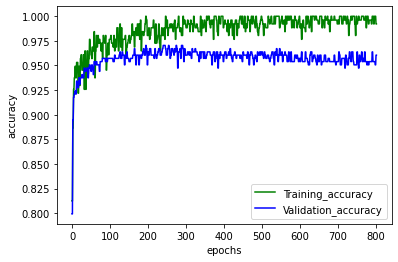

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.ticker as plticker

#ymin = 0 
#ymax = 1
#axes = plt.gca()
#y = [0,0.3,0.5,0.8,1]
pn_train = [ast.literal_eval(i) for i in train_result]
pn_val = [ast.literal_eval(i) for i in val_result]

cv_train = [ast.literal_eval(i) for i in cov_train_result]
cv_val = [ast.literal_eval(i) for i in cov_val_result]
plt.plot(range(len(cv_train)), cv_train, 'g', label = 'Training_accuracy')
plt.axis([None, None, 0,None])
#plt.yticks(np.arange(min(y), max(y)+1, 1.0))
#loc = plticker.MultipleLocator(base=1.0)
#axes.yaxis.set_major_locator(loc)
#plt.yticks(computeTicks([0, 0.2, 0.5, 1]))
axes.set_yticks(y)

plt.plot(range(len(cv_train)), cv_val, 'b', label = 'Validation_accuracy')
axes.set_ylim(0,1)
plt.axis('tight')

plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()
plt.savefig('coss.pdf', bbox_inches='tight')


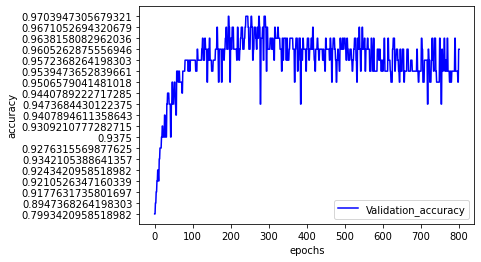

In [ ]:
plt.plot(cov_val_result, 'b', label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()
#plt.savefig('covid_validation.pdf', bbox_inches='tight')



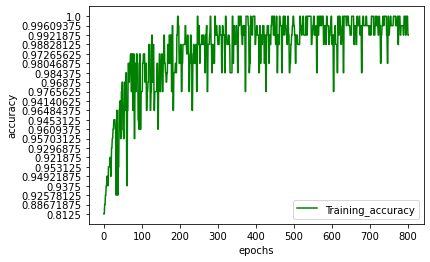

In [ ]:
plt.plot(range(len(cov_train_result)), cov_train_result, 'g', label = 'Training_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()
#plt.savefig('covid_train.pdf', bbox_inches='tight')


In [ ]:
!tail pneumonia_output.txt

INFO:tensorflow:Step 3980: loss = 0.01231382042169571 train acc = 1.0 val acc = 0.9539473652839661
I1015 21:28:47.442949 46912496410304 retrain.py:127] Step 3980: loss = 0.01231382042169571 train acc = 1.0 val acc = 0.9539473652839661
INFO:tensorflow:Step 3990: loss = 0.015081768855452538 train acc = 1.0 val acc = 0.9572368264198303
I1015 21:28:49.635408 46912496410304 retrain.py:127] Step 3990: loss = 0.015081768855452538 train acc = 1.0 val acc = 0.9572368264198303
INFO:tensorflow:Step 3999: loss = 0.016030561178922653 train acc = 1.0 val acc = 0.9572368264198303
I1015 21:28:51.636502 46912496410304 retrain.py:127] Step 3999: loss = 0.016030561178922653 train acc = 1.0 val acc = 0.9572368264198303
INFO:tensorflow:Best validation accuracy = 97.03947305679321
I1015 21:28:52.573166 46912496410304 retrain.py:141] Best validation accuracy = 97.03947305679321
INFO:tensorflow:Final test accuracy =  93.10897588729858
I1015 21:28:52.573410 46912496410304 retrain.py:142] Final test accuracy = 

In [ ]:
#for loss plots
import re
cov_loss_result=[]
with open("/content/covid_output.txt") as f:
    for line in f:
        s = re.search(r"(?<=loss\s=\s)\d+.\d+",line) # pattern matches up to "Y" followed by "=" and a space "\s" then a digit or digits. 
        if s: # if there is a match i.e re.search does not return None, add match to the list.
            cov_loss_result.append(s.group())
print (cov_loss_result)

['0.6205767393112183', '0.6205767393112183', '0.333340048789978', '0.333340048789978', '0.2314254641532898', '0.2314254641532898', '0.22154028713703156', '0.22154028713703156', '0.17200902104377747', '0.17200902104377747', '0.16891393065452576', '0.16891393065452576', '0.14547193050384521', '0.14547193050384521', '0.15848928689956665', '0.15848928689956665', '0.18531827628612518', '0.18531827628612518', '0.15654876828193665', '0.15654876828193665', '0.18430781364440918', '0.18430781364440918', '0.14075684547424316', '0.14075684547424316', '0.11969909071922302', '0.11969909071922302', '0.12900178134441376', '0.12900178134441376', '0.15356206893920898', '0.15356206893920898', '0.13166050612926483', '0.13166050612926483', '0.1607886552810669', '0.1607886552810669', '0.11335527896881104', '0.11335527896881104', '0.15062998235225677', '0.15062998235225677', '0.12566383183002472', '0.12566383183002472', '0.10579973459243774', '0.10579973459243774', '0.13080129027366638', '0.13080129027366638

In [ ]:
print(classification_report(cv_train, pn_train))

<class 'list'>
<class 'list'>
[0.6233289241790771, 0.6233289241790771, 0.3391433358192444, 0.3391433358192444, 0.24967104196548462, 0.24967104196548462, 0.22983364760875702, 0.22983364760875702, 0.18556015193462372, 0.18556015193462372, 0.17864607274532318, 0.17864607274532318, 0.19948089122772217, 0.19948089122772217, 0.19600442051887512, 0.19600442051887512, 0.22097092866897583, 0.22097092866897583, 0.15766841173171997, 0.15766841173171997, 0.09409601241350174, 0.09409601241350174, 0.16506558656692505, 0.16506558656692505, 0.14168629050254822, 0.14168629050254822, 0.11553214490413666, 0.11553214490413666, 0.11939484626054764, 0.11939484626054764, 0.14662112295627594, 0.14662112295627594, 0.13665705919265747, 0.13665705919265747, 0.12622633576393127, 0.12622633576393127, 0.20014545321464539, 0.20014545321464539, 0.10477642714977264, 0.10477642714977264, 0.09656956791877747, 0.09656956791877747, 0.11705606430768967, 0.11705606430768967, 0.11963366717100143, 0.11963366717100143, 0.12825

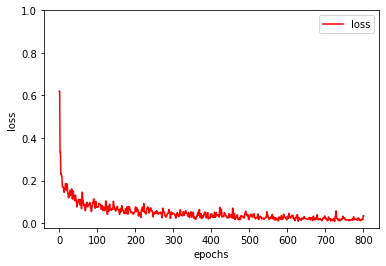

In [ ]:
import numpy
import ast

covid_loss = [ast.literal_eval(i) for i in cov_loss_result]

epochs = range(len(loss_result))
subset_p_loss = loss_result[0:20]
subset_p_loss.sort(reverse=True)
print(type(cov_loss_result))
Y_label = tf.constant(1.)
subset_p_loss = (list(np.array(subset_p_loss)))

print(type(dd))
print(dd)
plt.plot(covid_loss, 'r', label = 'loss')
#plt.plot(epochs, train_result, 'r', label = 'train')
#plt.plot(epochs, val_result, 'r', label = 'val')


#plt.axis( ymax = 0.2, ymin = 0)
#axes = plt.gca()
#axes.set_ylim(0,20)
plt.ylim(plt.ylim()[0], 1.0)

plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()
#plt.savefig('pneumonia_loss.pdf', bbox_inches='tight')


In [ ]:
#output of my covid run  when I ran on my labs hpc cluster 

!tail -10000 /content/covid_output.txt

INFO:tensorflow:Creating Bottleneck at /tmp/bottleneck/train/COVID/BACTERIA-3893778-0001.jpeg_inception_v3.txt
I1017 19:13:57.380363 46912496418496 train.py:95] Creating Bottleneck at /tmp/bottleneck/train/COVID/BACTERIA-3893778-0001.jpeg_inception_v3.txt
INFO:tensorflow:Creating Bottleneck at /tmp/bottleneck/train/COVID/BACTERIA-3893778-0002.jpeg_inception_v3.txt
I1017 19:13:57.700560 46912496418496 train.py:95] Creating Bottleneck at /tmp/bottleneck/train/COVID/BACTERIA-3893778-0002.jpeg_inception_v3.txt
INFO:tensorflow:Creating Bottleneck at /tmp/bottleneck/train/COVID/BACTERIA-3893778-0003.jpeg_inception_v3.txt
I1017 19:13:57.987703 46912496418496 train.py:95] Creating Bottleneck at /tmp/bottleneck/train/COVID/BACTERIA-3893778-0003.jpeg_inception_v3.txt
INFO:tensorflow:Creating Bottleneck at /tmp/bottleneck/train/COVID/BACTERIA-3896855-0001.jpeg_inception_v3.txt
I1017 19:13:58.284787 46912496418496 train.py:95] Creating Bottleneck at /tmp/bottleneck/train/COVID/BACTERIA-3896855-000

In [ ]:

print((loss_result))

['0.6233289241790771', '0.6233289241790771', '0.3391433358192444', '0.3391433358192444', '0.24967104196548462', '0.24967104196548462', '0.22983364760875702', '0.22983364760875702', '0.18556015193462372', '0.18556015193462372', '0.17864607274532318', '0.17864607274532318', '0.19948089122772217', '0.19948089122772217', '0.19600442051887512', '0.19600442051887512', '0.22097092866897583', '0.22097092866897583', '0.15766841173171997', '0.15766841173171997', '0.09409601241350174', '0.09409601241350174', '0.16506558656692505', '0.16506558656692505', '0.14168629050254822', '0.14168629050254822', '0.11553214490413666', '0.11553214490413666', '0.11939484626054764', '0.11939484626054764', '0.14662112295627594', '0.14662112295627594', '0.13665705919265747', '0.13665705919265747', '0.12622633576393127', '0.12622633576393127', '0.20014545321464539', '0.20014545321464539', '0.10477642714977264', '0.10477642714977264', '0.09656956791877747', '0.09656956791877747', '0.11705606430768967', '0.11705606430

In [ ]:
#output of my pneumonia run
!tail pneumonia_output.txt

INFO:tensorflow:Step 3980: loss = 0.01231382042169571 train acc = 1.0 val acc = 0.9539473652839661
I1015 21:28:47.442949 46912496410304 retrain.py:127] Step 3980: loss = 0.01231382042169571 train acc = 1.0 val acc = 0.9539473652839661
INFO:tensorflow:Step 3990: loss = 0.015081768855452538 train acc = 1.0 val acc = 0.9572368264198303
I1015 21:28:49.635408 46912496410304 retrain.py:127] Step 3990: loss = 0.015081768855452538 train acc = 1.0 val acc = 0.9572368264198303
INFO:tensorflow:Step 3999: loss = 0.016030561178922653 train acc = 1.0 val acc = 0.9572368264198303
I1015 21:28:51.636502 46912496410304 retrain.py:127] Step 3999: loss = 0.016030561178922653 train acc = 1.0 val acc = 0.9572368264198303
INFO:tensorflow:Best validation accuracy = 97.03947305679321
I1015 21:28:52.573166 46912496410304 retrain.py:141] Best validation accuracy = 97.03947305679321
INFO:tensorflow:Final test accuracy =  93.10897588729858
I1015 21:28:52.573410 46912496410304 retrain.py:142] Final test accuracy = 